<a href="https://colab.research.google.com/github/SylwiaNowakowska/Diffusion_Models_Medical_Imaging/blob/main/Prompt2MedicalImageEvaluation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install diffusers transformers accelerate
!pip install -q datasets diffusers transformers accelerate torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.2 MB/s eta 0:00:00
  Using cached accelerate-0.23.0-py3-none-any.whl (258 kB)
  Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.2 MB/s eta 0:00:00


In [3]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Stable Diffusion model from CompVis - genration of medical images

In [4]:
model_id = 'CompVis/stable-diffusion-v1-4'

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

prompts = ["Chest X-ray of healthy lungs",
           "MRI axial slice of a healthy brain",
           "Computed tomography slice knee",
           "Ultrasound of baby in 21st week of pregnancy"]

images_general = pipe(prompts, num_images_per_prompt=1, output_type="numpy").images

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:340: FutureWarning: the output_type numpy is outdated and has been set to `np`. Please make sure to set it to one of these instead: `pil`, `np`, `pt`, `latent`
  deprecate("Unsupported output_type", "1.0.0", deprecation_message, standard_warn=False)


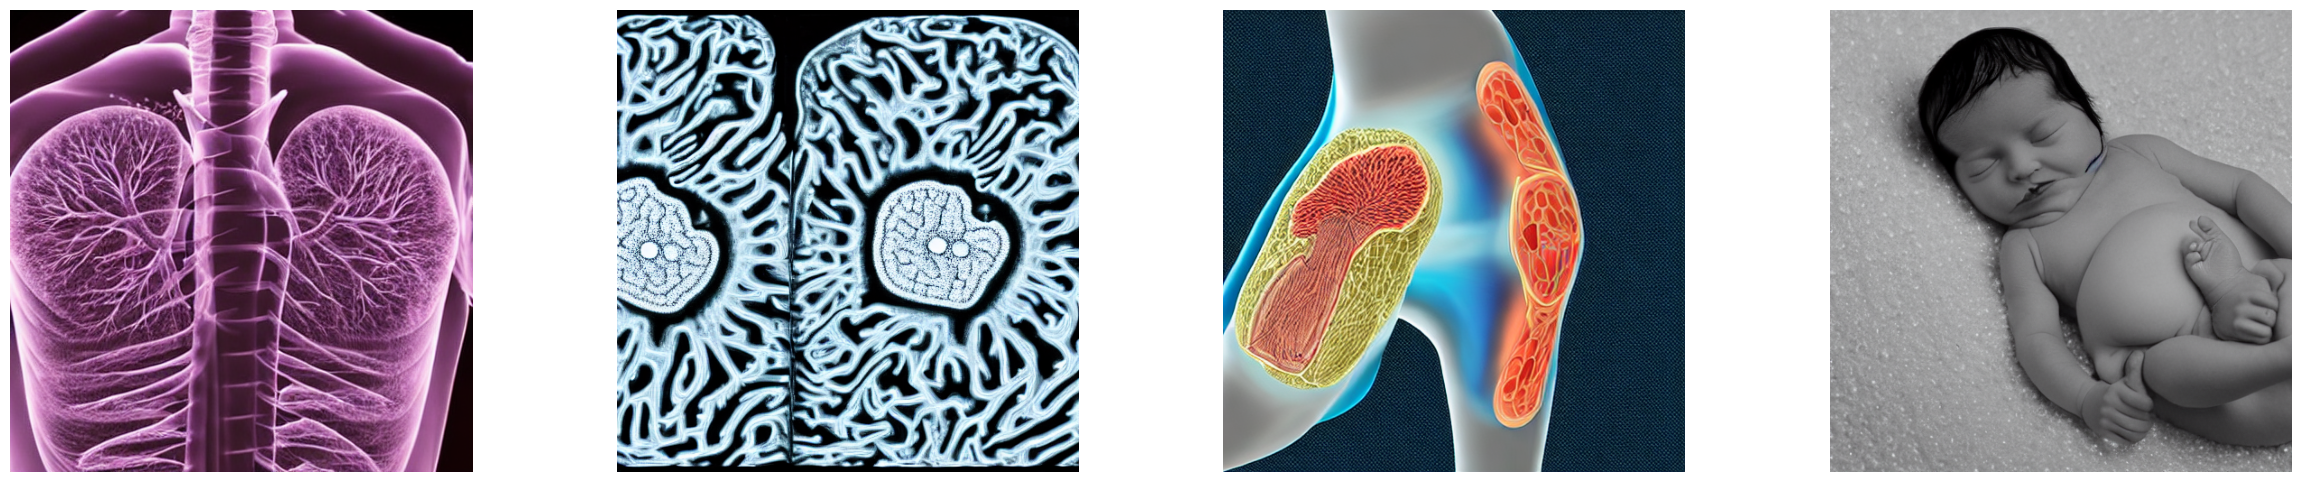

In [5]:
columns = len(prompts)

fig, axs = plt.subplots(1, columns, figsize=(30,6))
axs = axs.flatten()
for i in range(columns):
    axs[i].imshow(images_general[i, :, :, :])
    axs[i].axis('off')

In [7]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

def calculate_clip_score(images, prompts, clip_score_fn):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

# general purpose clip model
clip_score_fn_general = partial(clip_score, model_name_or_path='openai/clip-vit-base-patch16')

# clip model fine-tuned on medical image-text pairs
clip_score_fn_medical = partial(clip_score, model_name_or_path='flaviagiammarino/pubmed-clip-vit-base-patch32')

sd_clip_score_general = calculate_clip_score(images_general, prompts, clip_score_fn_general)
sd_clip_score_medical = calculate_clip_score(images_general, prompts, clip_score_fn_medical)
print(f"CLIP score: {sd_clip_score_general}")
print(f"CLIP score: {sd_clip_score_medical}")

CLIP score: 29.0823
CLIP score: 27.0985


## Stable Diffusion model fine-tuned on ROCO Medical Dataset

In [8]:
model_id = "Nihirc/Prompt2MedImage"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

images_medical = pipe(prompts, num_images_per_prompt=1, output_type="numpy").images

vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:340: FutureWarning: the output_type numpy is outdated and has been set to `np`. Please make sure to set it to one of these instead: `pil`, `np`, `pt`, `latent`
  deprecate("Unsupported output_type", "1.0.0", deprecation_message, standard_warn=False)


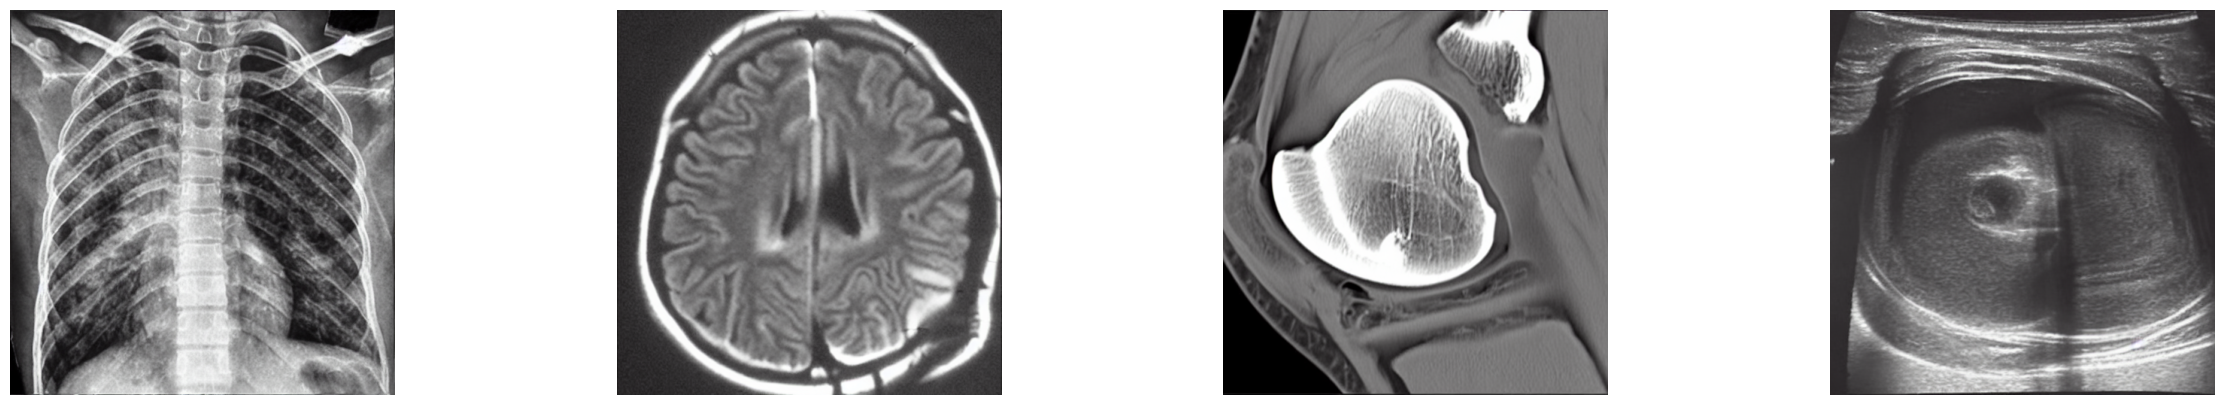

In [9]:
fig, axs = plt.subplots(1, columns, figsize=(30,5))
axs = axs.flatten()
for i in range(columns):
    axs[i].imshow(images_medical[i, :, :, :])
    axs[i].axis('off')

In [11]:
sd_clip_score_general = calculate_clip_score(images_medical, prompts, clip_score_fn_general)
sd_clip_score_medical = calculate_clip_score(images_medical, prompts, clip_score_fn_medical)
print(f"CLIP score: {sd_clip_score_general}")
print(f"CLIP score: {sd_clip_score_medical}")

CLIP score: 32.2368
CLIP score: 29.0487
